# TCAV for Model Explainability

In [1]:
#!pip3 install torch torchvision

In [2]:
#!pip install captum

In [35]:
import numpy as np
import os, glob

import matplotlib.pyplot as plt

from PIL import Image

from scipy.stats import ttest_ind

# ..........torch imports............
import torch
import torchvision

from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms

#.... Captum imports..................
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str

In [36]:
# Method to normalize an image to Imagenet mean and standard deviation
def transform(img):

    return transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )(img)

In [37]:
def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("RGB")
    return transform(img)


def load_image_tensors(class_name, root_path='data/tcav/image/imagenet/', transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')

    tensors = []
    for filename in filenames:
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img)
    
    return tensors

In [38]:
def assemble_concept(name, id, concepts_path="data/tcav/image/concepts/"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)

In [39]:
!mkdir -p ./data/tcav/image/concepts
!mkdir -p ./data/tcav/image/concepts/striped
!mkdir -p ./data/tcav/image/concepts/zigzagged
!mkdir -p ./data/tcav/image/concepts/dotted

In [8]:
!cp -r ./tcav/tcav/tcav_examples/image_models/imagenet/YOUR_PATH/striped/* ./data/tcav/image/concepts/striped/
!cp -r ./tcav/tcav/tcav_examples/image_models/imagenet/YOUR_PATH/zigzagged/* ./data/tcav/image/concepts/zigzagged/
!cp -r ./tcav/tcav/tcav_examples/image_models/imagenet/YOUR_PATH/dotted/* ./data/tcav/image/concepts/dotted/

In [9]:
!mkdir -p ./data/tcav/image/concepts/random_0
!mkdir -p ./data/tcav/image/concepts/random_1
!mkdir -p ./data/tcav/image/concepts/random_2
!mkdir -p ./data/tcav/image/concepts/random_3

In [10]:
!cp -r ./tcav/tcav/tcav_examples/image_models/imagenet/YOUR_PATH/random500_0/* ./data/tcav/image/concepts/random_0/
!cp -r ./tcav/tcav/tcav_examples/image_models/imagenet/YOUR_PATH/random500_1/* ./data/tcav/image/concepts/random_1/
!cp -r ./tcav/tcav/tcav_examples/image_models/imagenet/YOUR_PATH/random500_2/* ./data/tcav/image/concepts/random_2/
!cp -r ./tcav/tcav/tcav_examples/image_models/imagenet/YOUR_PATH/random500_3/* ./data/tcav/image/concepts/random_3/

In [11]:
concepts_path = "data/tcav/image/concepts/"

stripes_concept = assemble_concept("striped", 0, concepts_path=concepts_path)
zigzagged_concept = assemble_concept("zigzagged", 1, concepts_path=concepts_path)
dotted_concept = assemble_concept("dotted", 2, concepts_path=concepts_path)


random_0_concept = assemble_concept("random_0", 3, concepts_path=concepts_path)
random_1_concept = assemble_concept("random_1", 4, concepts_path=concepts_path)

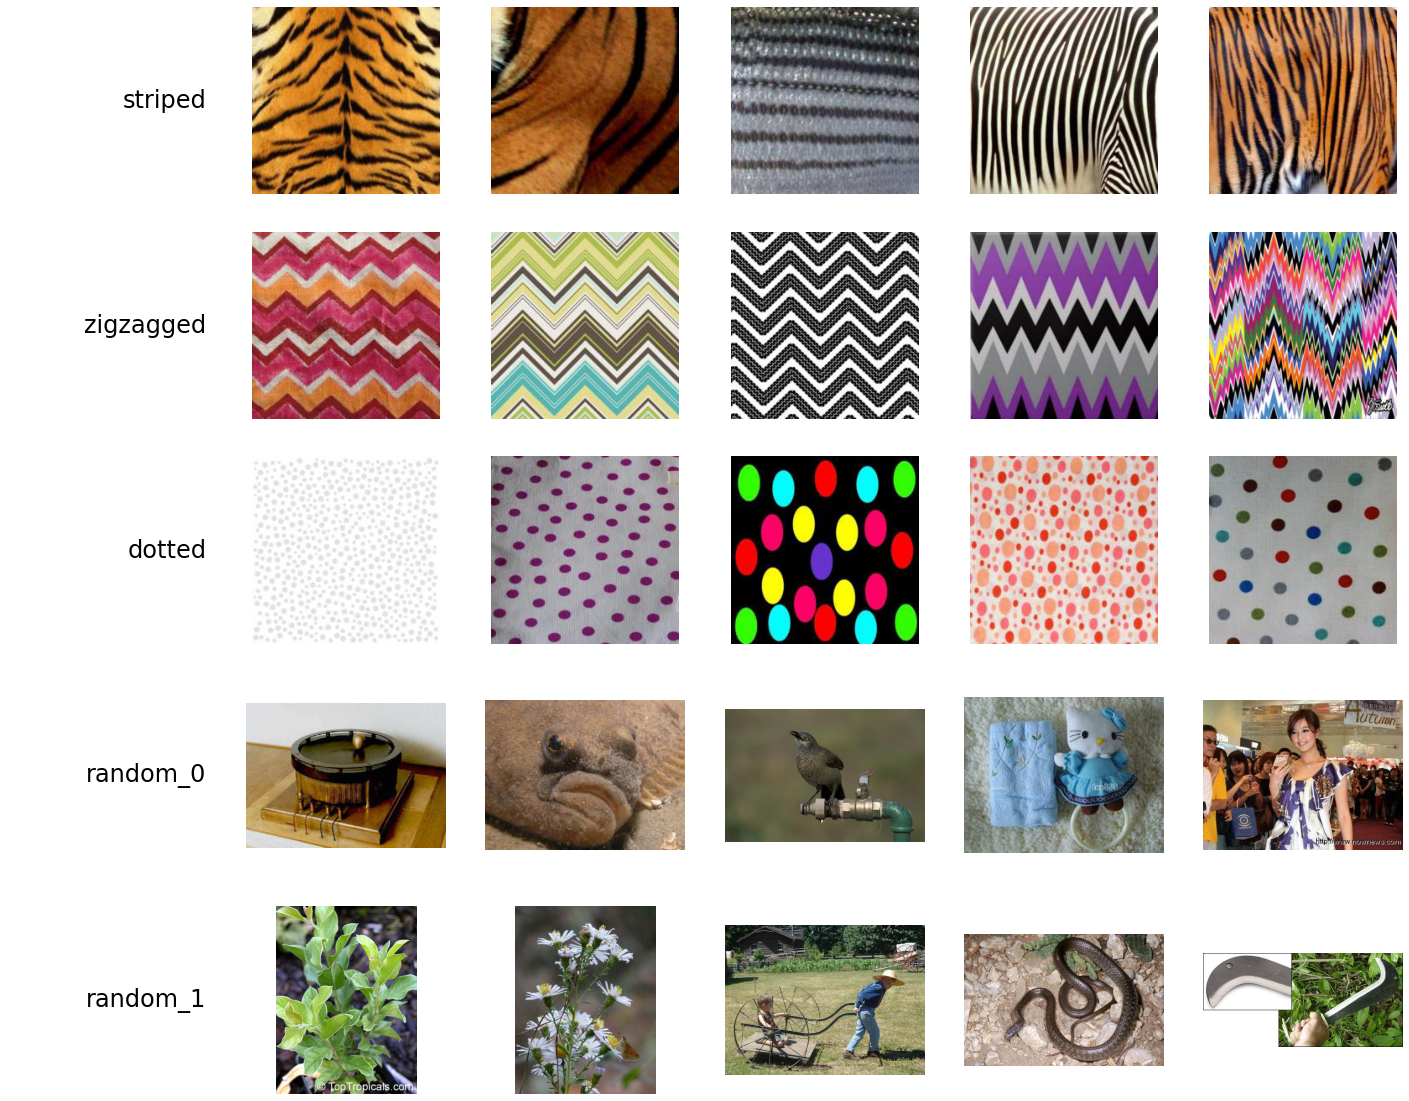

In [40]:
n_figs = 5
n_concepts = 5

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([stripes_concept, zigzagged_concept, dotted_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

In [41]:
model = torchvision.models.googlenet(pretrained=True)
model = model.eval()

In [42]:
# Define the model to use for TCAV
model = torchvision.models.googlenet(pretrained=True)
model = model.eval()

# Set the layers to test
layers=['inception4c', 'inception4d', 'inception4e']

# Define the layer attribution method for TCAV
attribution_method = LayerIntegratedGradients(model,
                                              None,
                                              multiply_by_inputs=False)
model_tcav = TCAV(model=model,
                  layers=layers,
                  layer_attr_method = attribution_method)

/opt/conda/lib/python3.7/site-packages/captum/concept/_utils/classifier.py:131: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  "Using default classifier for TCAV which keeps input"


In [15]:
experimental_set_rand = [[stripes_concept, random_0_concept], [stripes_concept, random_1_concept]]

In [16]:
!mkdir -p ./data/tcav/image/imagenet/zebra

In [17]:
!cp ./tcav/tcav/tcav_examples/image_models/imagenet/YOUR_PATH/zebra/* ./data/tcav/image/imagenet/zebra/

In [18]:
# Load sample images from folder
zebra_imgs = load_image_tensors('zebra', transform=False)

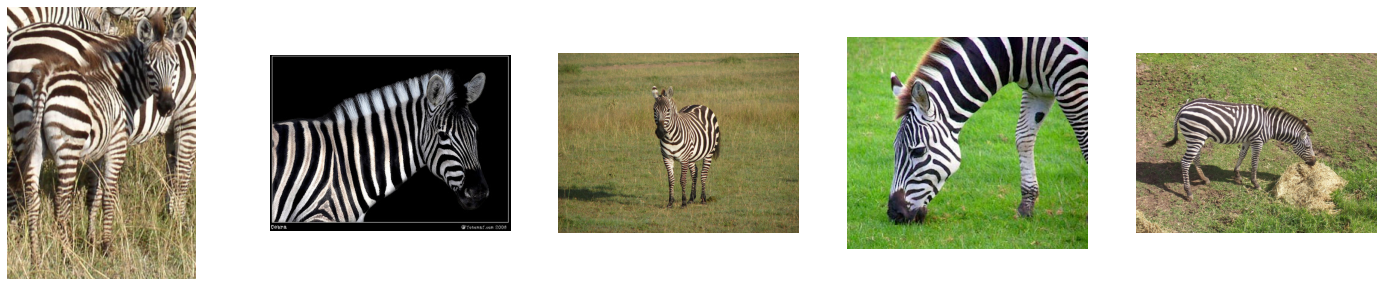

In [19]:
fig, axs = plt.subplots(1, 5, figsize = (25, 5))
for i in range(5):
    axs[i].imshow(zebra_imgs[2*i])
    axs[i].axis('off')

plt.show()

In [20]:
# Load sample images from folder
zebra_tensors = torch.stack([transform(img) for img in zebra_imgs])
experimental_set_rand

[[Concept(0, 'striped'), Concept(3, 'random_0')],
 [Concept(0, 'striped'), Concept(4, 'random_1')]]

In [21]:
# zebra class index
zebra_ind = 340

# collect the Captum concepts for stripes and random
experimental_set_rand = [
    [stripes_concept, random_0_concept],
    [stripes_concept, random_1_concept]]

# use TCA to interpret a collection on zebra images
tcav_scores_w_random = model_tcav.interpret(
    inputs=zebra_tensors,
    experimental_sets=experimental_set_rand,
    target=zebra_ind,
    n_steps=5)

tcav_scores_w_random

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-3': defaultdict(None,
                         {'inception4c': {'sign_count': tensor([0.7714, 0.2286]),
                           'magnitude': tensor([ 1.0968, -1.0968])},
                          'inception4d': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 2.1345, -2.1345])},
                          'inception4e': {'sign_count': tensor([0.9714, 0.0286]),
                           'magnitude': tensor([ 0.7379, -0.7379])}}),
             '0-4': defaultdict(None,
                         {'inception4c': {'sign_count': tensor([0.7429, 0.2571]),
                           'magnitude': tensor([ 0.6923, -0.6923])},
                          'inception4d': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 2.8063, -2.8063])},
                          'inception4e': {'sign_count': tensor([0.8571, 0.1429]),
                

In [22]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

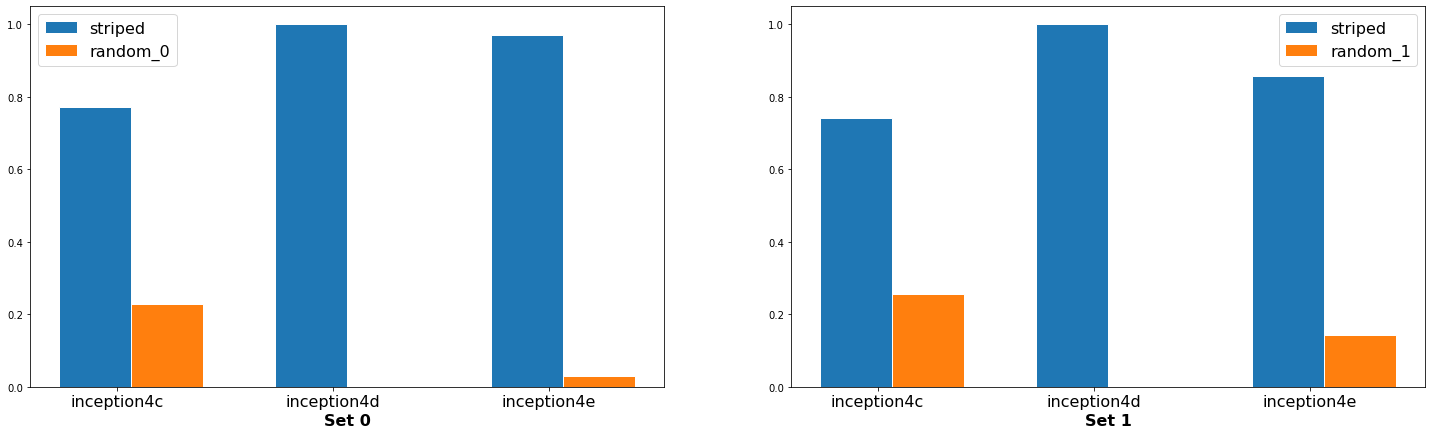

In [23]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random)

In [24]:
experimental_set_zig_dot = [[stripes_concept, zigzagged_concept, dotted_concept]]

In [25]:
tcav_scores_w_zig_dot = mytcav.interpret(inputs=zebra_tensors,
                                         experimental_sets=experimental_set_zig_dot,
                                         target=zebra_ind,
                                         n_steps=5)

/opt/conda/lib/python3.7/site-packages/captum/_utils/models/linear_model/train.py:351: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  bias_values = torch.FloatTensor([sklearn_model.intercept_]).to(  # type: ignore
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


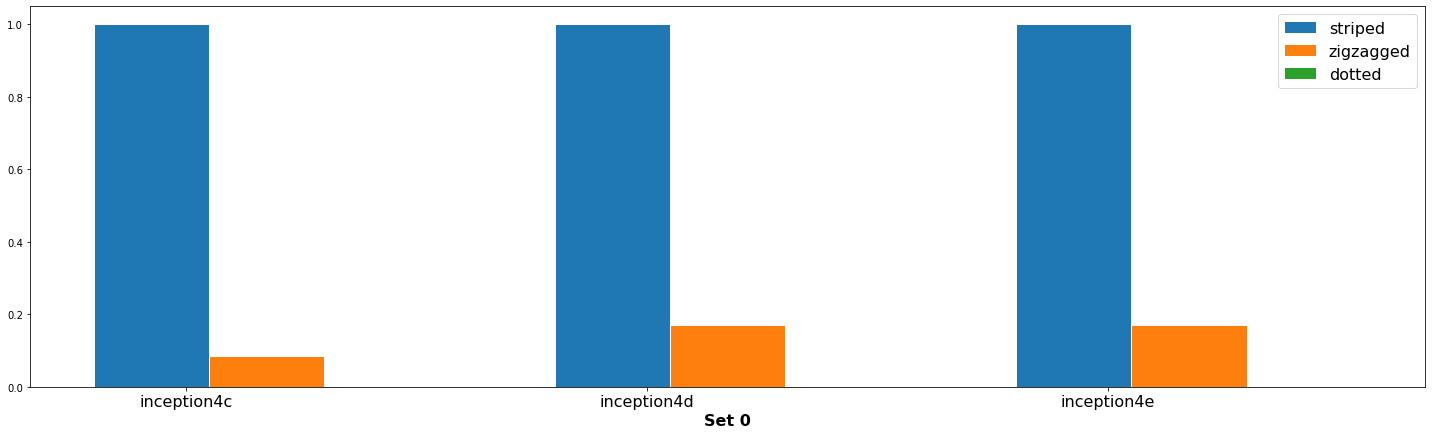

In [26]:
plot_tcav_scores(experimental_set_zig_dot, tcav_scores_w_zig_dot)    

In [27]:
!mkdir -p ./data/tcav/image/imagenet/cockatoo
!cp ./tcav/tcav/tcav_examples/image_models/imagenet/YOUR_PATH/cockatoo/* ./data/tcav/image/imagenet/cockatoo/

In [28]:
# Load sample images from folder
cockatoo_imgs = load_image_tensors('cockatoo', transform=False)

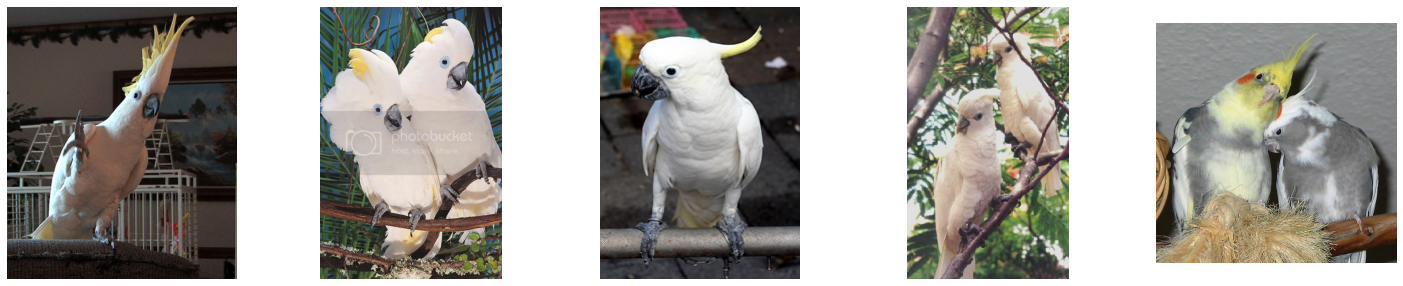

In [29]:
fig, axs = plt.subplots(1, 5, figsize = (25, 5))
for i in range(5):
    axs[i].imshow(cockatoo_imgs[i])
    axs[i].axis('off')

plt.show()

In [30]:
# Load sample images from folder
cockatoo_tensors = torch.stack([transform(img) for img in cockatoo_imgs])
experimental_set_rand

[[Concept(0, 'striped'), Concept(3, 'random_0')],
 [Concept(0, 'striped'), Concept(4, 'random_1')]]

In [33]:
# zebra class index
cockatoo_ind = 89


tcav_scores_w_random = mytcav.interpret(inputs=cockatoo_tensors,
                                        experimental_sets=experimental_set_rand,
                                        target=cockatoo_ind,
                                        n_steps=5,
                                       )
tcav_scores_w_random

defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-3': defaultdict(None,
                         {'inception4c': {'sign_count': tensor([0.1429, 0.8571]),
                           'magnitude': tensor([-1.3973,  1.3973])},
                          'inception4d': {'sign_count': tensor([0.3571, 0.6429]),
                           'magnitude': tensor([-0.5798,  0.5798])},
                          'inception4e': {'sign_count': tensor([0.8571, 0.1429]),
                           'magnitude': tensor([ 0.4328, -0.4328])}}),
             '0-4': defaultdict(None,
                         {'inception4c': {'sign_count': tensor([0.3571, 0.6429]),
                           'magnitude': tensor([-0.1927,  0.1927])},
                          'inception4d': {'sign_count': tensor([0.7143, 0.2857]),
                           'magnitude': tensor([ 0.1779, -0.1779])},
                          'inception4e': {'sign_count': tensor([0.5714, 0.4286]),


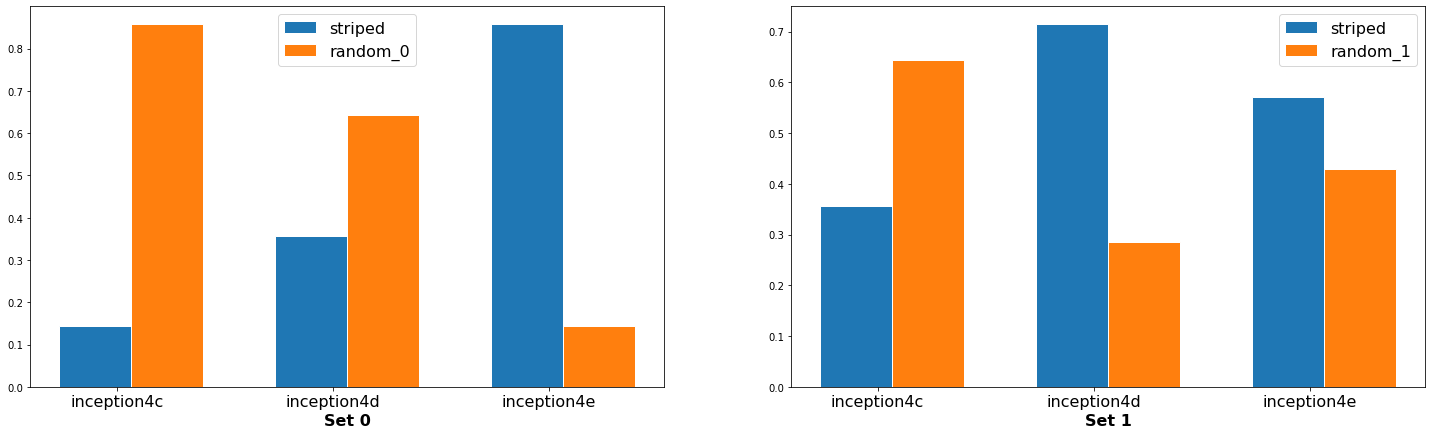

In [34]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random)